In [82]:
#################################################################### Loading packages ####################################################################
import sys as sys
import os
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
import pickle
import math 
import re
from Censored_copula import *
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import euclidean_distances 
import pandas as pd
from scipy.optimize import dual_annealing
from joblib import Parallel, delayed
import psutil
from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise_distances
from sklearn.gaussian_process.kernels import Matern

#################################################################### Loading GNM ####################################################################
model_version = 0 
target_distribution = "gamma_hurdle"
base_nn = "HConvLSTM_tdscale"
sys.path.append('../')

import pickle

path_ = f"Checkpoints/uk_rain_DGLM_{base_nn}_{target_distribution}/lightning_logs/version_{model_version}/"
#ckpt_path = glms.NeuralDGLM.get_ckpt_path(os.path.join(path_,"checkpoints"))
ckpt_path = 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_0/checkpoints/epoch=3-step=9008-val_loss_loss=-0.552-val_metric_mse_rain=26.500.ckpt'
print([path_,ckpt_path])
'''
scaler_features, scaler_target = glms.NeuralDGLM.load_scalers(path_)
model = glms.NeuralDGLM.load_from_checkpoint(ckpt_path, save_hparams=False, scaler_features=scaler_features, scaler_target=scaler_target)
model.freeze()
model.eval()
'''
GNM_output = pickle.load( open(os.path.join(path_,"test_output_1999-07_2019-07_test20y.pkl"),"rb") )

#################################################################### Problematic locations? ###############################################################

location_keys = list(GNM_output.keys())                 # '([0, 16], [44, 60])', ...
output_keys = list(GNM_output[location_keys[0]].keys()) # 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'mask', 7'idx_loc_in_region'


# May have to remove a location that doesn't have the correct number of days:
location_keys.remove(location_keys[344]) #to remove for gamma_20_20
#location_keys.remove(location_keys[171]) # to remove for gamma_20_20_unseen
#location_keys.remove(location_keys[312 ]) # to remove for gamma_robustness_test

#################################################################### Utility functions ####################################################################
def give_lat_lon(location_key):
    return [ int(re.findall(r'\d+',string)[0]) for string in location_key.split(',')]

def is_loc_land(location,row,column):
    return GNM_output[location]['mask'][0][row][column]

#location_keys.remove('lat_50.95_49.35_lon_-4.55_-2.95') # 'lat_50.95_49.35_lon_-4.55_-2.95' has no data after week indexed 255, so I did not consider it.
day_dates = [pd.to_datetime(i).date() for i in GNM_output[location_keys[0]]['date']]
output_keys.remove('idx_loc_in_region') # not usefull
output_keys.remove('date') # no more usefull

#################################################################### Making list for land locations ####################################################################
#GNM_landonly[location][param][day]
# 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'

GNM_landonly = [] 
land_counter = -1
for location in tqdm(location_keys):
    for col in range(4):
        for row in range(4):
            if not is_loc_land(location,row,col):#check if land
               continue  
            land_counter+=1
            GNM_landonly.append([[],[],[],[],[]]) # parameters except location
            temp_lat_lon = give_lat_lon(location)
            GNM_landonly[land_counter].append([temp_lat_lon[1]-8+row,(temp_lat_lon[2])+6+col]) #location
            for param_idx,param in enumerate(output_keys[:-1]):
                for day in range(len(GNM_output[location_keys[0]]['pred_mu'])):
                    qqq = [location,param,day,row,col]
                    GNM_landonly[land_counter][param_idx].append(GNM_output[location][param][day][row,col])

dist_mat = distance_matrix(np.matrix([[GNM_landonly[loc][5][0],GNM_landonly[loc][5][1]] for loc in range(len(GNM_landonly))]),np.matrix([[GNM_landonly[loc][5][0],GNM_landonly[loc][5][1]] for loc in range(len(GNM_landonly))]))

#################################################################### Elevation data ####################################################################
import netCDF4 as nc
fn = 'topo_0.1_degree.nc'
ds = nc.Dataset(fn)
h = ds['Band1'][:]
h = np.flip(np.matrix(h),axis=0)
topo_dist = euclidean_distances(np.array([h[loc[5][0],loc[5][1]+2] for loc in GNM_landonly]).reshape(-1,1))

['Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_0/', 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_0/checkpoints/epoch=3-step=9008-val_loss_loss=-0.552-val_metric_mse_rain=26.500.ckpt']


100%|██████████| 344/344 [02:22<00:00,  2.41it/s]


# Warwing: check if the correct locations were removed

# Diagnostics

### Marginals

In [17]:
# Draw time-series plot with quantiles for predicted vs trget rain at a given location. ~3s 
# Just change values at the top.

#ts_plot_location = 3055
for ts_plot_location in [954]:
    print(ts_plot_location)
    ts_plot_left_lim,ts_plot_right_lim = ts_plot_location+0,ts_plot_location+0+360

    #################################################################### Do not touch the rest ####################################################################
    import matplotlib.dates as mdates

    # mean and 68, 95 percentiles 
    g_median = []
    g_q25 = []
    g_q75 = []
    g_q68 = []
    g_q95 = []
    g_q32 = []
    g_q05 = []

    #GNM_landonly[location][param][day]
    ## 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'

    #gamma_outputs [place][parameter][day][row][column]
    # 0 'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'location'.

    for m,d,i in zip([GNM_landonly[ts_plot_location][0][i] for i in range(len(GNM_landonly[0][0]))],[GNM_landonly[ts_plot_location][1][i] for i in range(len(GNM_landonly[0][0]))],range(len(GNM_landonly[0][0]))) :
        rv = scs.gamma(scale=m*d,a=1/d)  
        
        g_median.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.5)/GNM_landonly[ts_plot_location][4][i]))
        g_q25.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.25)/GNM_landonly[ts_plot_location][4][i]))
        g_q75.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.75)/GNM_landonly[ts_plot_location][4][i]))
        g_q95.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.95)/GNM_landonly[ts_plot_location][4][i]))
        g_q05.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.05)/GNM_landonly[ts_plot_location][4][i]))

    for q in [g_median,g_q25,g_q05,g_q32,g_q68,g_q75,g_q95]:
        for i in range(len(q)):
            if math.isnan(q[i]):
                q[i]=0
                
    plt.figure(figsize=(25, 8),dpi=700)
    plt.plot(day_dates,g_q05,color='skyblue',linewidth=0.6,alpha=1,label='forecast percentiles 05 to 95')
    plt.plot(day_dates,g_q25,color='navy',linewidth=0.6,alpha=1,label='forecast percentiles 25 to 75')
    plt.plot(day_dates,g_median,color='blue',linewidth=1,alpha=1,label='forcast median')
    plt.plot(day_dates,g_q75,color='navy',linewidth=0.6,alpha=1)
    plt.plot(day_dates,g_q95,color='skyblue',linewidth=0.6,alpha=1)
    plt.fill_between(day_dates, g_median, g_q75, where=([g_median[k] < g_q75[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='navy', alpha=0.6,interpolate=True)
    plt.fill_between(day_dates, g_median, g_q25, where=([g_median[k] > g_q25[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='navy', alpha=0.6,interpolate=True)
    plt.fill_between(day_dates, g_q95, g_q75, where=([g_q95[k] > g_q75[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='skyblue', alpha=0.6,interpolate=True)
    plt.fill_between(day_dates, g_q05, g_q25, where=([g_q05[k] < g_q25[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='skyblue', alpha=0.6,interpolate=True)
    plt.scatter(day_dates,[GNM_landonly[ts_plot_location][3][i] for i in range(len(GNM_landonly[0][0]))],color='r',marker='1',s=20,label='observed rain')
    plt.plot(day_dates,[GNM_landonly[ts_plot_location][3][i] for i in range(len(GNM_landonly[0][0]))],color='r',alpha=0.6,linewidth=0.3)
    plt.xlim((day_dates[ts_plot_left_lim],day_dates[ts_plot_right_lim]))
    plt.title('Gamma model at location '+str(GNM_landonly[ts_plot_location][5]))
    plt.xlabel('Day index')
    plt.ylabel('Precipitation (mm)')
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.show()

500


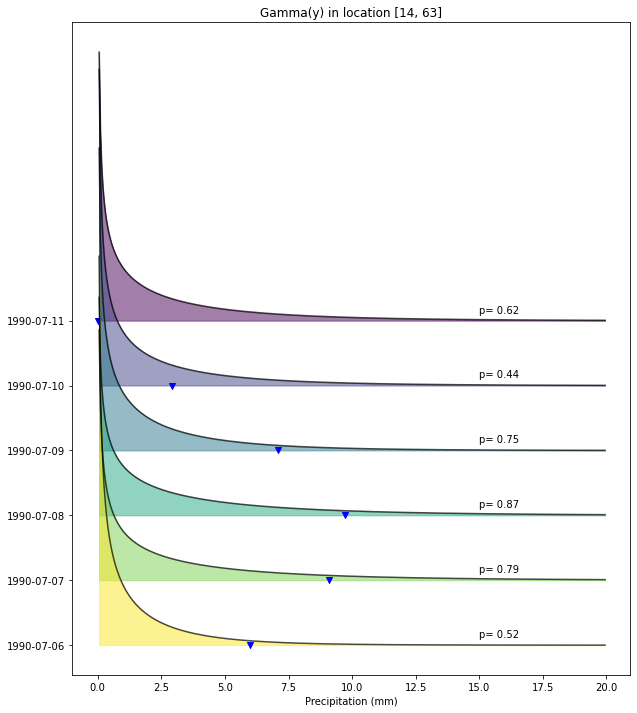

In [21]:
# Densities plots
# Just change values at the top.

density_plot_location = 111
density_plot_start,density_plot_end = 370,376

#################################################################### Do not touch the rest ####################################################################
import matplotlib

x=[i/20 for i in range(400)]
plt.figure(figsize=(10,(density_plot_end-density_plot_start)*2))
colors = matplotlib.cm.viridis(np.linspace(0, 1, len(range(density_plot_end,density_plot_start,-1))))
for idx,col in zip(reversed(range(density_plot_start-1,density_plot_end)),colors):
    rv=scs.gamma(scale=[GNM_landonly[density_plot_location][1][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx]*[GNM_landonly[density_plot_location][0][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx],a=1/[GNM_landonly[density_plot_location][1][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx])
    level=(-0.3+(idx+1-density_plot_start)*0.25)
    plt.plot(x,level+rv.pdf(x),color='black',alpha=0.7)
    plt.fill_between(x,y1=level+rv.pdf(x),y2=level,where=([level+rv.pdf(x_)>level for x_ in x]),color=col,alpha=0.5)
    plt.text(15,level+0.03,'p= '+str(round([GNM_landonly[density_plot_location][4][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx],2)))
    plt.scatter([GNM_landonly[density_plot_location][3][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx],level,marker='v',color='b')
plt.xlabel('Precipitation (mm)')
plt.title('Gamma(y) in location '+str(GNM_landonly[density_plot_location][5]))
plt.yticks([-0.3+(idx-density_plot_start)*0.25 for idx in range(density_plot_end,density_plot_start,-1)],reversed([pd.to_datetime(i).date() for i in GNM_output[location_keys[0]]['date'][density_plot_start:density_plot_end]]))
#plt.yticks([-0.3+(idx-density_plot_start)*0.25 for idx in range(density_plot_end,density_plot_start,-1)],[k for k in range([density_plot_start:density_plot_end]])
plt.show()

### Simulations

In [83]:
sim_test = scs.multivariate_normal(mean=np.zeros(len(dist_mat)),cov= np.nan_to_num(Matern(length_scale=350,nu=3.5).__call__(0.95*dist_mat+((1-0.95)/70)*topo_dist)) ,allow_singular=True).rvs(size=100)

def GNM_x_to_y(x_one_day_all_locs,day_idx):
    m = np.array([GNM_landonly[l][0][day_idx] for l in range(len(x_one_day_all_locs))])
    d = np.array([GNM_landonly[l][1][day_idx] for l in range(len(x_one_day_all_locs))])
    p = np.array([GNM_landonly[l][4][day_idx] for l in range(len(x_one_day_all_locs))])
    sim_u = scs.norm.cdf(x_one_day_all_locs)
    censored_u = (sim_u+p-1)/p
    return np.nan_to_num(scs.gamma(a=1/d,scale=m*d).ppf(censored_u),nan=0)
    

In [117]:
len(sim_test)

100

In [86]:
day_subset=np.random.choice(range(len(GNM_landonly[0][0])),500,replace=False)
sims_all_copula = []
for d in tqdm(day_subset):
    sims_all_copula.append([GNM_x_to_y([sim_test[s][l] for l in range(len(GNM_landonly))],d) for s in range(100)])

100%|██████████| 500/500 [14:29<00:00,  1.74s/it]


In [16]:
len(np.mean([GNM_x_to_y(sim_test[s],330) for s in range(100)],axis=0))

4087

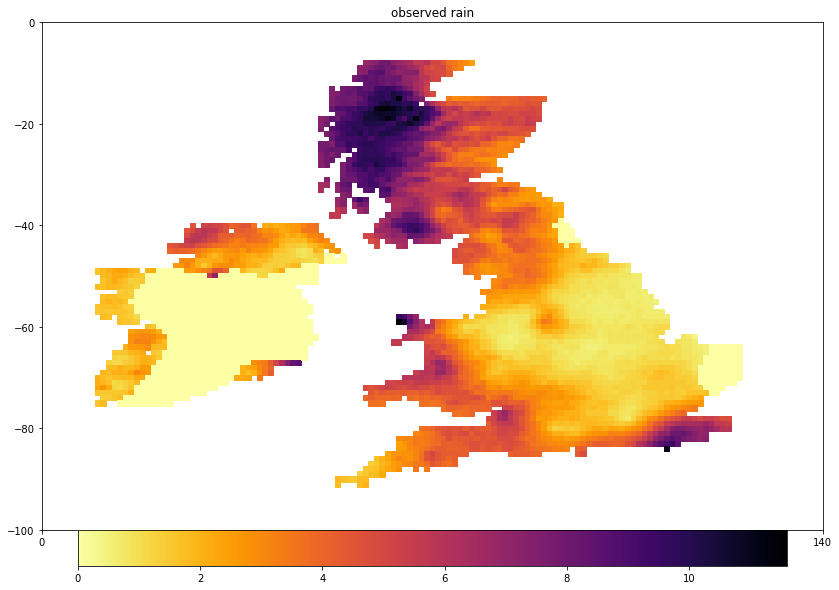

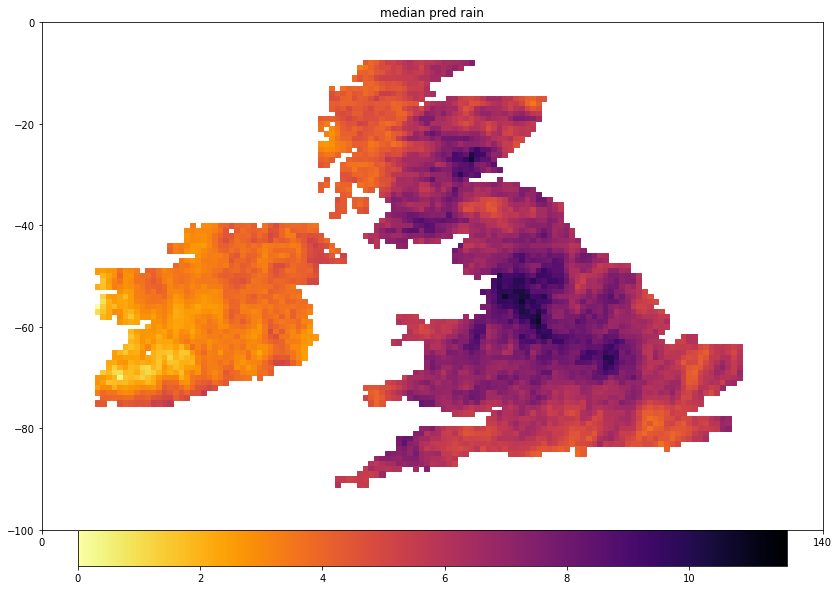

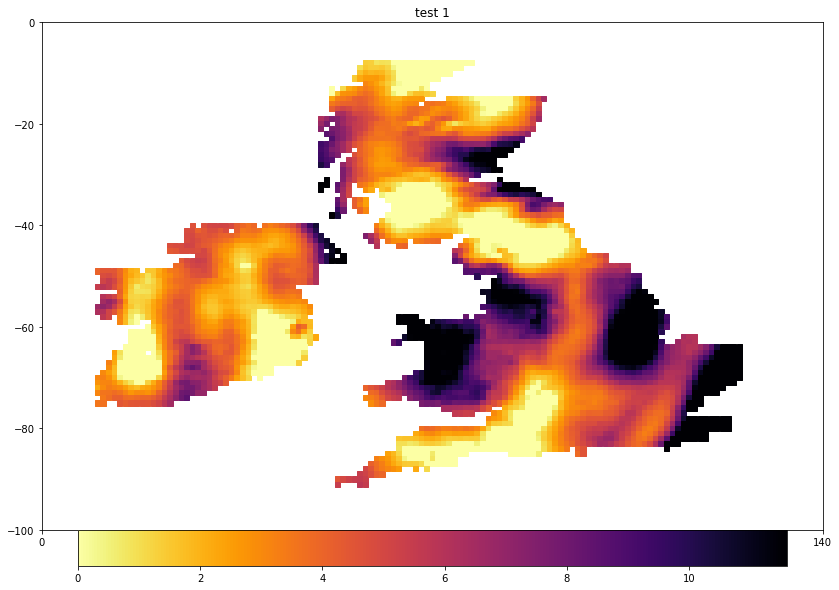

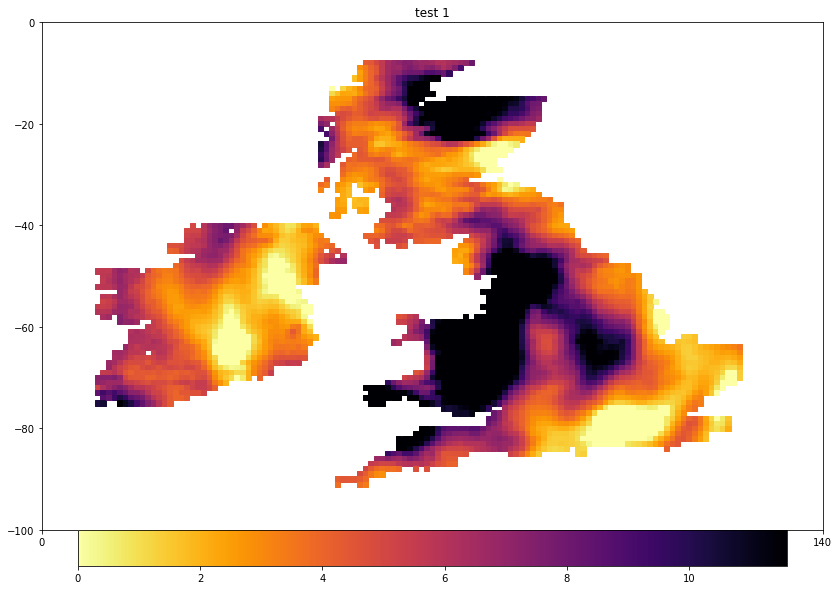

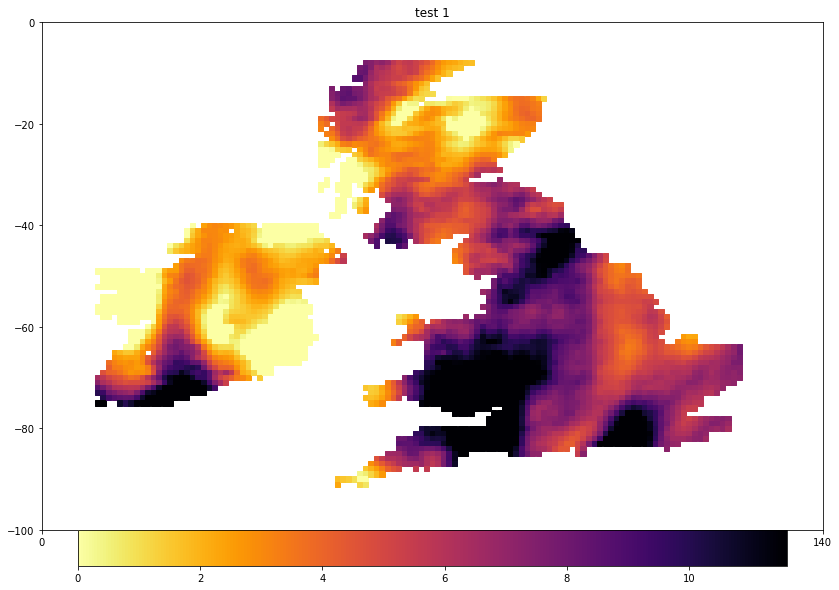

In [84]:
#plot sampled normals uncensored or cenored and transformed

day_index = 510

fig = plt.gcf() 
fig.set_size_inches(14,10)
plt.xlim(0,140)
plt.ylim(-100,0)
plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=[GNM_landonly[l][3][day_index] for l in range(len(GNM_landonly))][:len(sim_test[0])],cmap='inferno_r',s=27,marker='s')
plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
plt.title('observed rain')
plt.show()

min_rain = min([GNM_landonly[l][3][day_index] for l in range(len(GNM_landonly))])
max_rain = max([GNM_landonly[l][3][day_index] for l in range(len(GNM_landonly))])

fig = plt.gcf() 
fig.set_size_inches(14,10)
plt.xlim(0,140)
plt.ylim(-100,0)
plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=np.median([GNM_x_to_y(sim_test[s],day_index) for s in range(25)],axis=0),cmap='inferno_r',s=27,marker='s',vmin=min_rain,vmax=max_rain)
plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
plt.title('median pred rain')
plt.show()

for idx,sim in enumerate(sim_test[:3]):
    plt.xlim(0,140)
    plt.ylim(-100,0)
    fig = plt.gcf() 
    fig.set_size_inches(14,10)
    plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=GNM_x_to_y(sim,day_index),cmap='inferno_r',s=27,marker='s',vmin=min_rain,vmax=max_rain)
    plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
    plt.title('test 1')
    plt.show()

### Median forecast

In [49]:
g_median_all= np.nan_to_num(
    scs.gamma(
        a=np.array([[GNM_landonly[l][0][d] for l in range(len(GNM_landonly))] for d in tqdm(range(len(GNM_landonly[0][0])))]) , 
        scale=np.reciprocal(np.array([[GNM_landonly[l][1][d] for l in range(len(GNM_landonly))] for d in range(len(GNM_landonly[0][0]))])) 
        ).ppf(
            (np.array([[GNM_landonly[l][4][d] for l in range(len(GNM_landonly))] for d in range(len(GNM_landonly[0][0]))])-0.5
            )/(
                np.array([[GNM_landonly[l][4][d] for l in range(len(GNM_landonly))] for d in tqdm(range(len(GNM_landonly[0][0])))])
                )
            ), 
            nan=0,posinf=20,neginf=0)


100%|██████████| 10955/10955 [00:12<00:00, 901.04it/s] 


In [50]:
median_x_all = [np.median([sim_test[s] for s in range(25)],axis=0) for d in tqdm(day_subset)]

100%|██████████| 500/500 [00:01<00:00, 482.45it/s]


In [51]:
g_median_pred_all = []
for i,d in tqdm(enumerate(day_subset)):
    g_median_pred_all.append(GNM_x_to_y(median_x_all[i],d) )

500it [00:07, 70.85it/s]


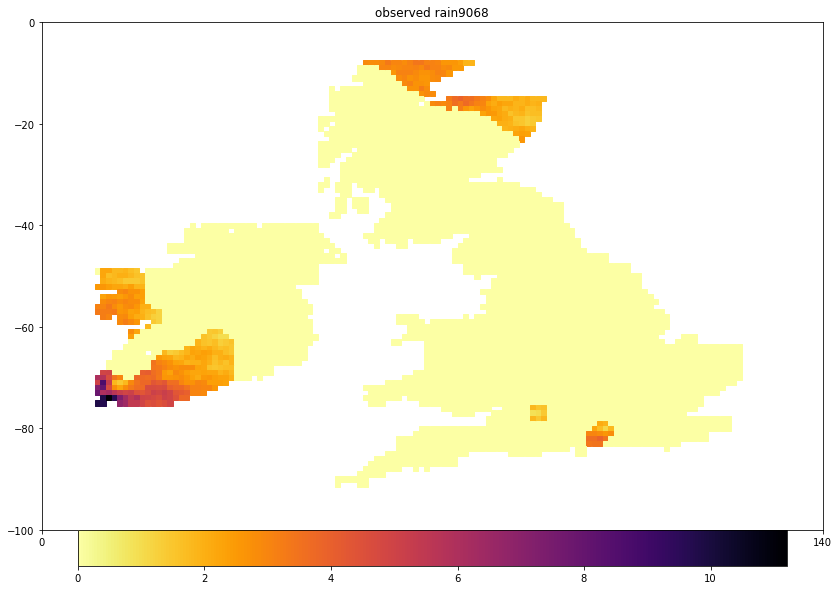

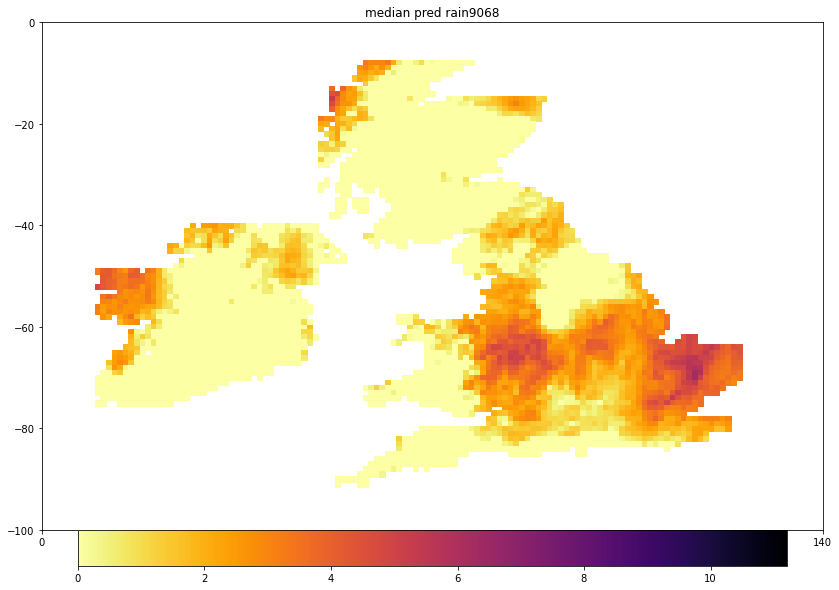

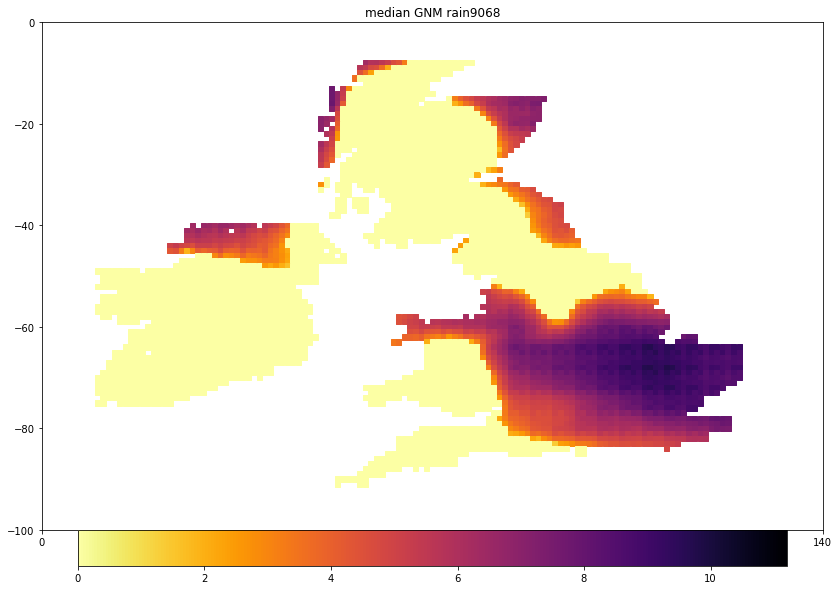

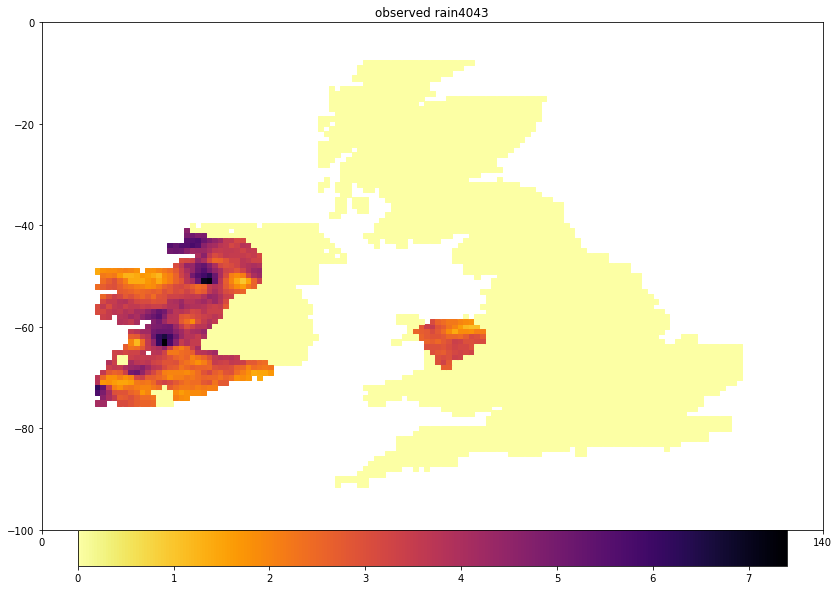

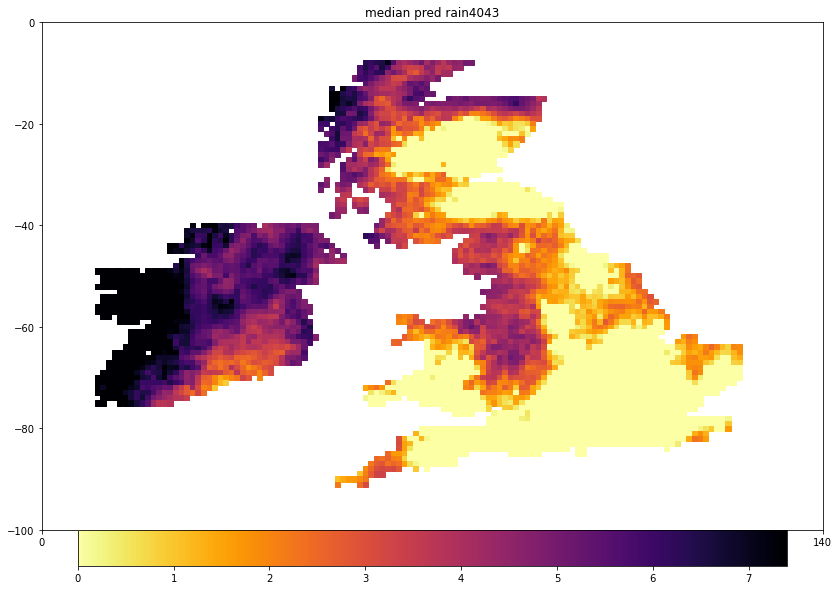

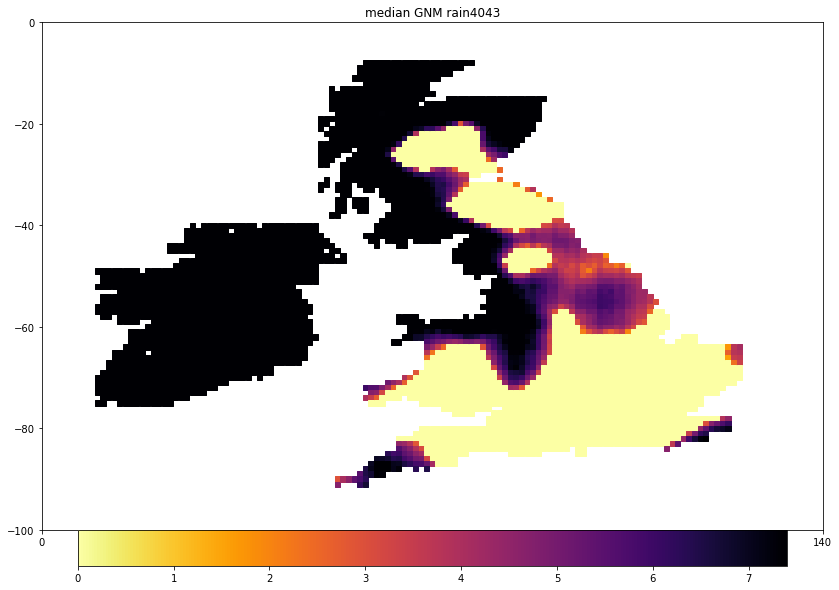

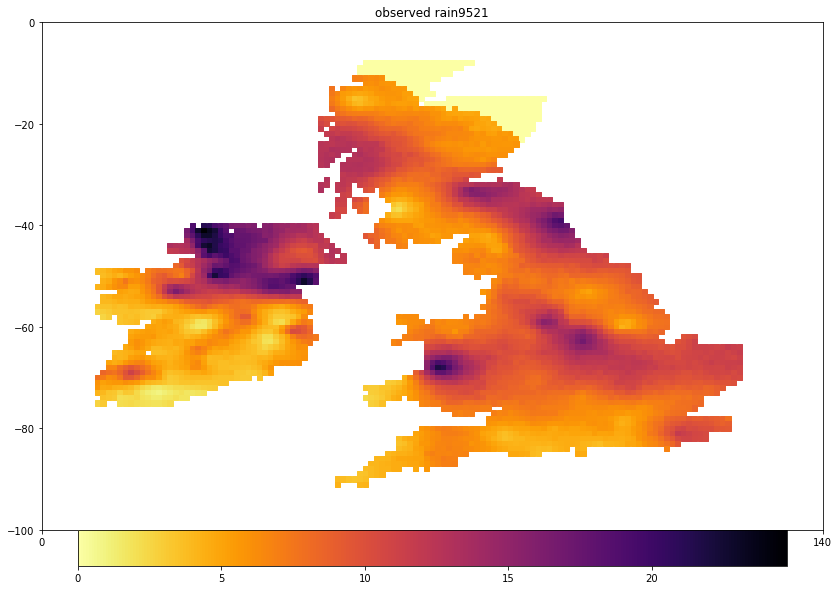

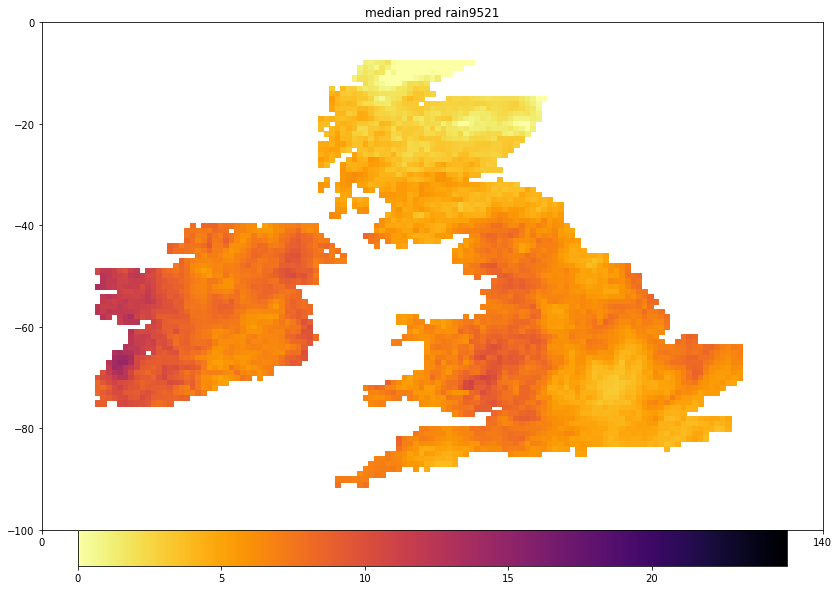

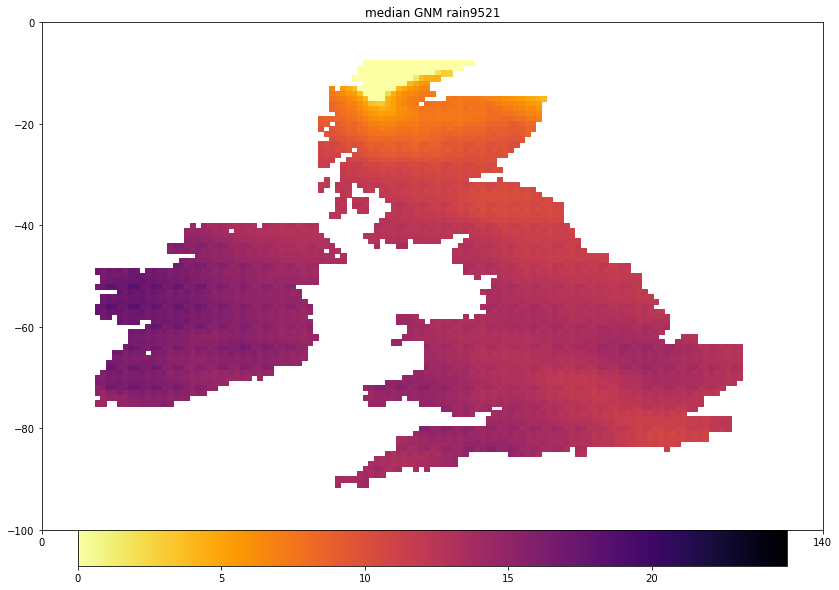

In [41]:
for i,m in enumerate(day_subset[:3]):
    min_rain = min([GNM_landonly[l][3][m] for l in range(len(GNM_landonly))])
    max_rain = max([GNM_landonly[l][3][m] for l in range(len(GNM_landonly))])

    fig = plt.gcf() 
    fig.set_size_inches(14,10)
    plt.xlim(0,140)
    plt.ylim(-100,0)
    plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=[GNM_landonly[l][3][m] for l in range(len(GNM_landonly))][:len(sim_test[0])],cmap='inferno_r',s=27,marker='s')
    plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
    plt.title('observed rain' + str(m))
    plt.show()

    fig = plt.gcf() 
    fig.set_size_inches(14,10)
    plt.xlim(0,140)
    plt.ylim(-100,0)
    plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=g_median_pred_all[i],cmap='inferno_r',s=27,marker='s',vmin=min_rain,vmax=max_rain)
    plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
    plt.title('median pred rain'+ str(m))
    plt.show()

    fig = plt.gcf() 
    fig.set_size_inches(14,10)
    plt.xlim(0,140)
    plt.ylim(-100,0)
    plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=g_median_all[m],cmap='inferno_r',s=27,marker='s',vmin=min_rain,vmax=max_rain)
    plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
    plt.title('median GNM rain'+ str(m))
    plt.show()

In [81]:
with open('topo_dist.txt','wb') as f:
    pickle.dump(topo_dist,f)

In [ ]:
# Median rain forecasts for all days and locations
#GNM_landonly[location][param][day]


# Used to get the vectors for all locations and all times, not needed after that.

g_median_all=[]

for loc in tqdm(range(len(GNM_landonly))):
    for day in range(len(GNM_landonly[0][1])):
        m,d = GNM_landonly[loc][0][day] , GNM_landonly[loc][1][day]
        rv = scs.gamma(scale=m*d,a=1/d)  
        g_median_all.append(rv.ppf((GNM_landonly[loc][4][day]-1+0.5)/GNM_landonly[loc][4][day]))

g_median_all = np.nan_to_num(g_median_all,copy=True)

with open('g_median_all_20y_20y.txt','wb') as f:
    pickle.dump(g_median_all,f)

'''
with open('g_median_all_20y_20y.txt','rb') as f:
    g_median_all = pickle.load(f)
g_median_all_test = np.nan_to_num(g_median_all,nan=0)
'''

100%|██████████| 4087/4087 [4:24:13<00:00,  3.88s/it]  


"\nwith open('g_median_all_20y_20y.txt','rb') as f:\n    g_median_all = pickle.load(f)\ng_median_all_test = np.nan_to_num(g_median_all,nan=0)\n"

In [ ]:
def get_median(locs,nb_days):
    g_median_all_=[]
    for loc in locs:
        for day in range(nb_days):
            m,d = GNM_landonly[loc][0][day] , GNM_landonly[loc][1][day]
            rv = scs.gamma(scale=m*d,a=1/d)  
            g_median_all_.append(rv.ppf((GNM_landonly[loc][4][day]-1+0.5)/GNM_landonly[loc][4][day]))

    

    return g_median_all_

In [ ]:
def get_median(locs,nb_days):
    g_median_all_=[]
    for loc in locs:
        for day in range(nb_days):
            g_median_all_.append((GNM_landonly[loc][4][day]-1+0.5)/GNM_landonly[loc][4][day])

    return g_median_all_

In [ ]:
from joblib import Parallel, delayed
import psutil

size = math.ceil(len(GNM_landonly)/psutil.cpu_count())
locs_chuncks = [[i for i in range(len(GNM_landonly))][x:x+size] for x in range(0,len(GNM_landonly), size)]
print(size,psutil.cpu_count(),len(locs_chuncks))
list_g_median_all = Parallel(n_jobs=psutil.cpu_count())(delayed(get_median)(chunck[:2],2) for chunck in tqdm(locs_chuncks))

511 8 8


100%|██████████| 8/8 [00:00<00:00, 83.58it/s]
c:\Users\u1819911\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


### ROC

In [244]:
def fast_roc(day,x):
   
   out = 1-(
         (1-np.array([GNM_landonly[l][4][day] for l in range(len(GNM_landonly))])) + 
         np.multiply(
            [GNM_landonly[l][4][day] for l in range(len(GNM_landonly))] , 
            scs.gamma( scale=[1/GNM_landonly[l][1][day] for l in range(len(GNM_landonly))] , 
                        a=[GNM_landonly[l][0][day] for l in range(len(GNM_landonly))]
               ).cdf(x)
            )        
      )

   return out

In [238]:
# getting vector of 'did it rain this much'
g_0mm=[]
g_5mm=[]
g_10mm=[]
g_15mm=[]
g_20mm=[]
g_25mm=[]

#GNM_landonly[location][param][day]
# 0'pred_alpha', 1'pred_beta', 2 rain>0 , 3'target_rain', 4 pred_p, 5 loc

def fast_roc(day,x):
   
   out = 1-(
         (1-np.array([GNM_landonly[l][4][day] for l in range(len(GNM_landonly))])) + 
         np.multiply(
            [GNM_landonly[l][4][day] for l in range(len(GNM_landonly))] , 
            scs.gamma( scale=[1/GNM_landonly[l][1][day] for l in range(len(GNM_landonly))] , 
                        a=[GNM_landonly[l][0][day] for l in range(len(GNM_landonly))]
               ).cdf(x)
            )        
      )

   return out


for d in tqdm(range(len(GNM_landonly[0][0]))):
   g_0mm.append(fast_roc(d,0.01))
   g_5mm.append(fast_roc(d,5))
   g_10mm.append(fast_roc(d,10))
   g_15mm.append(fast_roc(d,15))
   g_20mm.append(fast_roc(d,20))
   g_25mm.append(fast_roc(d,25))

g_0mm_did_rain=[]
g_5mm_did_rain=[]
g_10mm_did_rain=[]
g_15mm_did_rain=[]
g_20mm_did_rain=[]
g_25mm_did_rain=[]
def roc_didrain(day,x):
    return np.array([GNM_landonly[l][3][day] for l in range(len(GNM_landonly))])>x
for d in tqdm(range(len(GNM_landonly[0][0]))):
   g_0mm_did_rain.append(roc_didrain(d,0.01))
   g_5mm_did_rain.append(roc_didrain(d,5))
   g_10mm_did_rain.append(roc_didrain(d,10))
   g_15mm_did_rain.append(roc_didrain(d,15))
   g_20mm_did_rain.append(roc_didrain(d,20))
   g_25mm_did_rain.append(roc_didrain(d,25))

100%|██████████| 10955/10955 [03:25<00:00, 53.25it/s]


In [89]:
all_target_rain.shape

(4087, 500)

In [90]:
# ROC for samples
sims_all_copula = np.array(sims_all_copula)
g_0mm=np.mean(sims_all_copula>0,axis=1).flatten()
g_5mm=np.mean(sims_all_copula>5,axis=1).flatten()
g_10mm=np.mean(sims_all_copula>10,axis=1).flatten()
g_15mm=np.mean(sims_all_copula>15,axis=1).flatten()
g_20mm=np.mean(sims_all_copula>20,axis=1).flatten()
g_25mm=np.mean(sims_all_copula>25,axis=1).flatten()
all_target_rain = np.array([np.array([GNM_landonly[loc][3][day] for day in day_subset])for loc in range(4087)]).flatten().reshape(4087,len(day_subset))
g_0mm_did_rain=(all_target_rain.transpose()>0).flatten()
g_5mm_did_rain=(all_target_rain.transpose()>5).flatten()
g_10mm_did_rain=(all_target_rain.transpose()>10).flatten()
g_15mm_did_rain=(all_target_rain.transpose()>15).flatten()
g_20mm_did_rain=(all_target_rain.transpose()>20).flatten()
g_25mm_did_rain=(all_target_rain.transpose()>25).flatten()

In [91]:
# Restructuring data for ROC ~1m+3m/20y , 6m/30y
from sklearn import metrics
# g_25mm[loc][parallel run][0:rained more than x, 1:P it rained x][days]
roc_0_tf = np.array(g_0mm_did_rain).flatten()
roc_0_p = np.array(g_0mm).flatten()

roc_5_tf = np.array(g_5mm_did_rain).flatten()
roc_5_p = np.array(g_5mm).flatten()

roc_10_tf = np.array(g_10mm_did_rain).flatten()
roc_10_p = np.array(g_10mm).flatten()

roc_15_tf = np.array(g_15mm_did_rain).flatten()
roc_15_p = np.array(g_15mm).flatten()

roc_20_tf = np.array(g_20mm_did_rain).flatten()
roc_20_p = np.array(g_20mm).flatten()

roc_25_tf = np.array(g_25mm_did_rain).flatten()
roc_25_p = np.array(g_25mm).flatten()

###

fpr_0mm, tpr_0mm, _ = metrics.roc_curve(roc_0_tf,roc_0_p)
auc0 = metrics.roc_auc_score(roc_0_tf,roc_0_p)

fpr_5mm, tpr_5mm, _ = metrics.roc_curve(roc_5_tf,roc_5_p)
auc5 = metrics.roc_auc_score(roc_5_tf,roc_5_p)

fpr_10mm, tpr_10mm, _ = metrics.roc_curve(roc_10_tf,roc_10_p)
auc10 = metrics.roc_auc_score(roc_10_tf,roc_10_p)

fpr_15mm, tpr_15mm, _ = metrics.roc_curve(roc_15_tf,roc_15_p)
auc15 = metrics.roc_auc_score(roc_15_tf,roc_15_p)

fpr_20mm, tpr_20mm, _ = metrics.roc_curve(roc_20_tf,roc_20_p)
auc20 = metrics.roc_auc_score(roc_20_tf,roc_20_p)

fpr_25mm, tpr_25mm, _ = metrics.roc_curve(roc_25_tf,roc_25_p)
auc25 = metrics.roc_auc_score(roc_25_tf,roc_25_p)

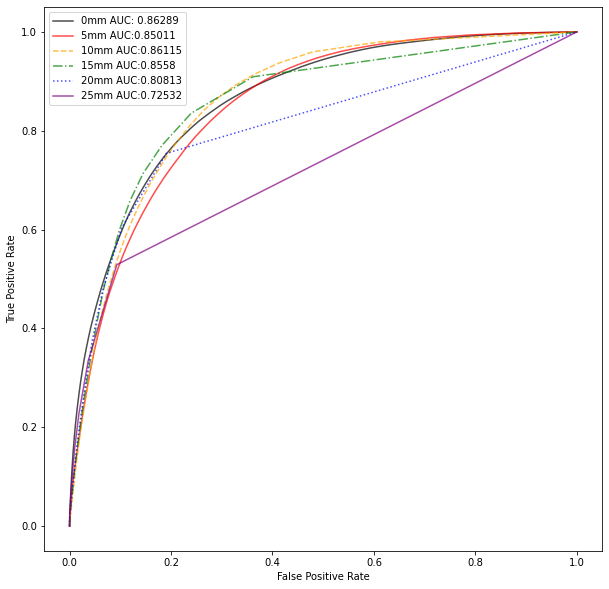

In [92]:
# ROC plot ~3m
plt.figure(figsize=(10,10))
plt.plot(fpr_0mm,tpr_0mm,label='AUC='+str(auc0),color='black',alpha=0.7)

plt.plot(fpr_5mm,tpr_5mm,label='AUC='+str(auc5),color='red',alpha=0.7)

plt.plot(fpr_10mm,tpr_10mm,label='AUC='+str(auc10),color='orange',alpha=0.7,linestyle='dashed')

plt.plot(fpr_15mm,tpr_15mm,label='AUC='+str(auc15),color='green',alpha=0.7,linestyle='dashdot')

plt.plot(fpr_20mm,tpr_20mm,label='AUC='+str(auc20),color='blue',alpha=0.7,linestyle='dotted')

plt.plot(fpr_25mm,tpr_25mm,label='AUC='+str(auc25),color='purple',alpha=0.7)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(['0mm AUC: '+str(round(auc0,5)),'5mm AUC:'+str(round(auc5,5)),'10mm AUC:'+str(round(auc10,5)),'15mm AUC:'+str(round(auc15,5)),'20mm AUC:'+str(round(auc20,5)),'25mm AUC:'+str(round(auc25,5))])
#plt.title('Gamma Model United Kingdom')
#plt.savefig('ROC Gamma model UK')

### Precision-Recall Curve

### Spread-Skill

In [ ]:
# Spread-Skill but with variance as spread directly.
 
RMS_spread = [] # should get 2002 entries, each being the average RMS across all locations and draws, for that day.
RMS_skill = [] # should get 2002 entries, each being the average RMS across all locations, for that day.

for day in tqdm(range(len(GNM_landonly[0][1]))):
    # The expression used below is the RMS spread for one day: a single number, the average variance across all locations.
    RMS_spread.append(
        np.mean( # average over samples and locations 
             [(GNM_landonly[loc][4][day]*np.power(GNM_landonly[loc][0][day],2)*(GNM_landonly[loc][1][day]+1) - np.power(GNM_landonly[loc][4][day],2)*np.power(GNM_landonly[loc][0][day],2)) for loc in range(len(GNM_landonly))
                ]))
    
    # The expression below is the RMS skill for one day: a single number giving the average across all locations of the squared difference of median forecast and target
    RMS_skill.append(
        np.mean( # average over locations
            np.power( # square
                np.subtract( # difference
                    np.transpose(np.array(g_median_all).reshape((len(GNM_landonly),7301)))[day,:] # median for that day across all locations
                    ,[GNM_landonly[loc][3][day] for loc in range(len(GNM_landonly))] ) # target rain for that day across all locations
                    ,2) # square
                    ))

100%|██████████| 7301/7301 [18:33<00:00,  6.55it/s]


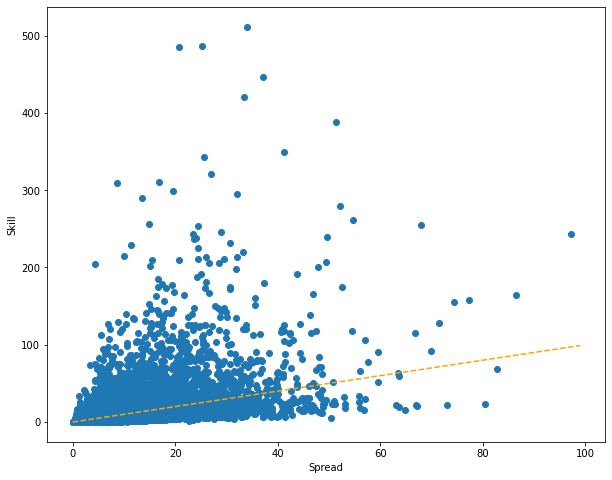

In [ ]:
# Skill-Spread over all days
plt.figure(figsize=(10,8))
plt.scatter(RMS_spread,RMS_skill)
plt.plot(range(100),range(100),color='orange',linestyle='--')
plt.ylabel('Skill')
plt.xlabel('Spread')

plt.show()

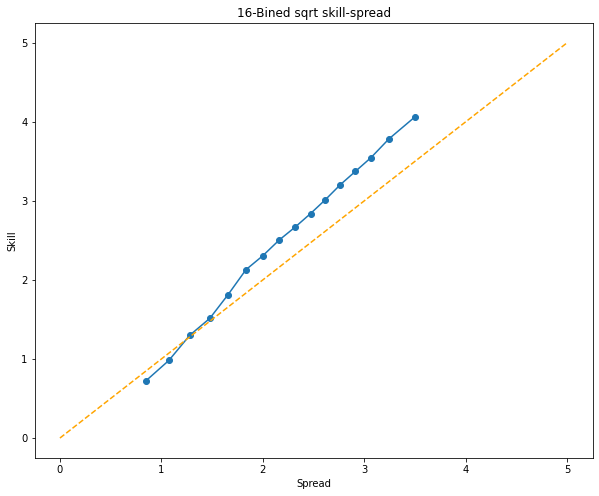

Text(0.5, 0, 'Spread')

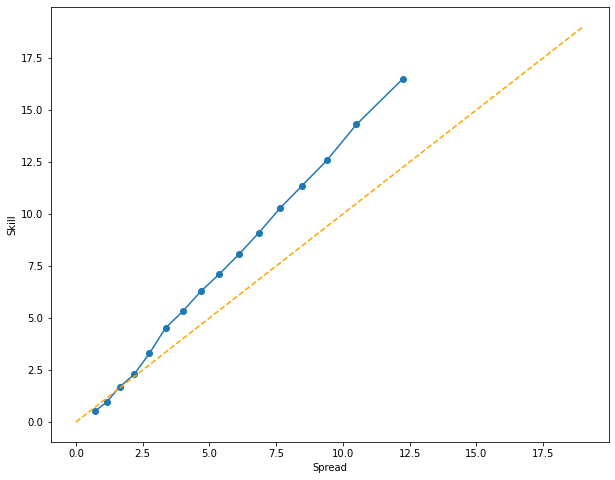

In [ ]:
# 16-Bined skill-spread - Need to draw samples of u first. 
# They are then used for each day.
binned_skill = [math.sqrt(np.mean(np.array(RMS_skill)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16)])) for q in range(1,17)]
binned_spread = [math.sqrt(np.mean(np.array(RMS_spread)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16)])) for q in range(1,17)]
plt.figure(figsize=(10,8))
plt.plot(binned_spread,binned_skill,'-o')
plt.plot(range(6),range(6),color='orange',linestyle='--')
plt.ylabel('Skill')
plt.xlabel('Spread')
plt.title('16-Bined sqrt skill-spread')
#plt.xlim(10,25)
#plt.ylim(5,20)
plt.show()
binned_skill = [np.mean(np.array(RMS_skill)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16)]) for q in range(1,17)]
binned_spread = [np.mean(np.array(RMS_spread)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16)]) for q in range(1,17)]
plt.figure(figsize=(10,8))

plt.plot(binned_spread,binned_skill,'-o')
plt.plot(range(20),range(20),color='orange',linestyle='--')
plt.ylabel('Skill')
plt.xlabel('Spread')


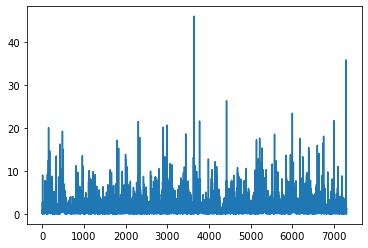

In [ ]:
plt.plot(np.divide(RMS_skill,RMS_spread))

### 1 - ecdf

In [53]:
len(np.median([GNM_x_to_y(sim_test[s],0) for s in range(100)],axis=0))

4087

100%|██████████| 10955/10955 [00:46<00:00, 236.52it/s]


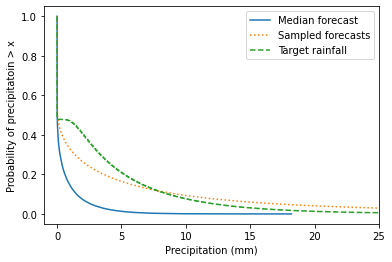

In [272]:
# P(rain>x) ~1m15 now. depending on samples and days used. 
from statsmodels.distributions.empirical_distribution import ECDF

# get empirical cdfs for median, sampled and target rain.
gamma_ecdf = ECDF(np.array(g_median_pred_all).flatten())
target_ecdf = ECDF(np.array([np.array([GNM_landonly[loc][3][day] for loc in range(len(GNM_landonly))]) for day in tqdm(range(len(GNM_landonly[0][0])))]).flatten())
gamma_sampled_ecdf = ECDF(np.array(sims_all_copula).flatten())
plt.plot(gamma_ecdf.x,1-gamma_ecdf.y,label='Median forecast')
plt.plot(gamma_sampled_ecdf.x,1-gamma_sampled_ecdf.y,linestyle='dotted',label='Sampled forecasts')
plt.plot(target_ecdf.x,1-target_ecdf.y,linestyle='--',label='Target rainfall')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Probability of precipitatoin > x')
plt.xlim(-1,25)
plt.legend()

### RMSB MAB

In [18]:
# RMSB and MAB metrics across all days and locations ~4.9s
all_target_rain = np.array([np.array([GNM_landonly[loc][3][day]for day in range(len(GNM_landonly[0][0]))])for loc in range(4087)]).flatten().reshape(4087,len(GNM_landonly[0][0])) # [loc,day]
RMSB = math.sqrt(np.mean(np.power(np.subtract(all_target_rain,np.array(g_median_all).reshape((4087,len(GNM_landonly[0][0])))),2)))
MAB = np.mean(np.abs(all_target_rain-np.array(g_median_all).reshape((4087,len(GNM_landonly[0][0])))))
print('MAB = '+str(MAB)+', RMSB = '+str(RMSB))

NameError: name 'g_median_all' is not defined

In [15]:
# Plot RMSB and MAB across time, averaged over all locations. 
import matplotlib.dates as mdates
plt.figure(figsize=(25,8),dpi=700)

RMSB_matrix = np.power(np.subtract(all_target_rain,np.array(g_median_all).reshape((4087,len(GNM_landonly[0][0])))),2)
MAB_matrix = np.abs(all_target_rain-np.array(g_median_all).reshape((4087,len(GNM_landonly[0][0]))))
RMSB_ts = [math.sqrt(np.mean(RMSB_matrix[:,day])) for day in range(len(GNM_landonly[0][0]))]
MAB_ts = [np.mean(MAB_matrix[:,day]) for day in range(len(GNM_landonly[0][0]))]
plt.plot(day_dates,RMSB_ts,alpha=0.6,label='RMSB')
plt.plot(day_dates,MAB_ts,alpha=0.6,label='MAB')
plt.legend()

plt.ylabel('Precipitation bias (mm)')
plt.xlabel('Date')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=round(len(GNM_landonly[0][0])/15)))
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
plt.hist(RMSB_ts)
plt.title('RMSB across days')
plt.show()
plt.hist(MAB_ts)
plt.title('MAB across days')
plt.show()

### Bias Maps

In [ ]:
# Bias maps 2*2
test_arr = np.array([np.mean(sampled_rain_flatten_all.reshape(3,53118)[:,column]) for column in range(53118)]).reshape(13,4086)

MAB_map = [np.mean(MAB_matrix[loc,:]) for loc in range(4086)]
RMSB_map = [math.sqrt(np.mean(RMSB_matrix[loc,:])) for loc in range(4086)]
Bias_map = np.matrix(np.array(g_median_all).reshape((4087,2000))-all_target_rain).mean(1).tolist()[:-1]
day_subset = np.random.choice(range(2000),50)
Sampled_bias = np.divide(np.array([np.mean(test_arr[:,loc]) for loc in range(4086)])-np.array([np.mean(np.transpose(all_target_rain[loc,day_subset])) for loc in range(4086)]), # difference 
np.array([np.mean(np.transpose(all_target_rain[loc,day_subset])) for loc in range(4086)])) # normalize by average target

fig, axes = plt.subplots(nrows=2, ncols=2,sharex=True,sharey=True,figsize=(12.5,8.5))
for day,ax in tqdm(enumerate(axes.flat)):
    
    fig.set_dpi(500)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    if day==0:
        #ax.set_title('MAB of median', y=1.0, pad=-10,size=10)
        im=ax.scatter([GNM_landonly[loc][5][1] for loc in range(4086)],[-GNM_landonly[loc][5][0] for loc in range(4086)],c=MAB_map,s=3.3,marker='s')
        fig.colorbar(im,ax=ax,location='left',fraction=0.03,pad=0.001).ax.tick_params(labelsize=3) 
        
    elif day==1:
        #ax.set_title('RMSB of median', y=1.0, pad=-10,size=10)
        im=ax.scatter([GNM_landonly[loc][5][1] for loc in range(4086)],[-GNM_landonly[loc][5][0] for loc in range(4086)],c=RMSB_map,s=3.3,marker='s')
        fig.colorbar(im,ax=ax,location='left',fraction=0.03,pad=0.001)
    elif day==2:
        #ax.set_title('Bias of median', y=1.0, pad=-10,size=10)
        im=ax.scatter([GNM_landonly[loc][5][1] for loc in range(4086)],[-GNM_landonly[loc][5][0] for loc in range(4086)],c=Bias_map,cmap='BrBG',s=3.3,marker='s',vmin=-4,vmax=4)
        fig.colorbar(im,ax=ax,location='left',fraction=0.03,pad=0.001)
    else:
        #ax.set_title('Bias of 10 averaged samples', y=1.0, pad=-10,size=10)
        im=ax.scatter([GNM_landonly[loc][5][1] for loc in range(4086)],[-GNM_landonly[loc][5][0] for loc in range(4086)],c=Sampled_bias,cmap='BrBG',s=3.3,marker='s',vmin=-5,vmax=5)
        fig.colorbar(im,ax=ax,location='left',fraction=0.03,pad=0.001)

plt.show()

ValueError: cannot reshape array of size 29839187 into shape (4087,2000)

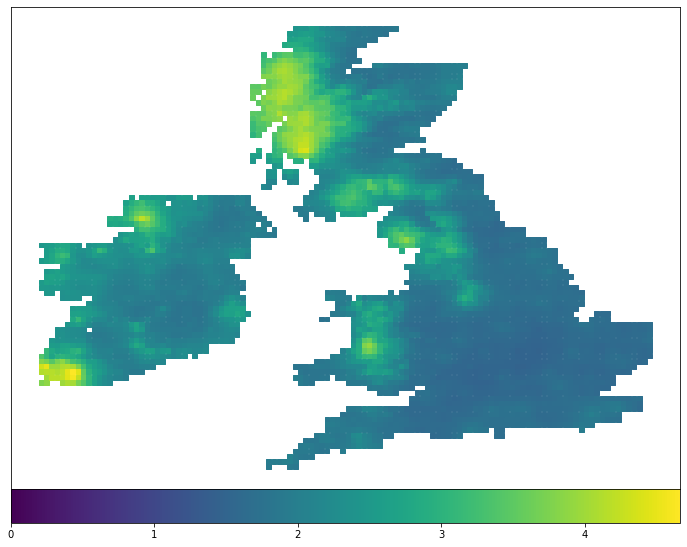

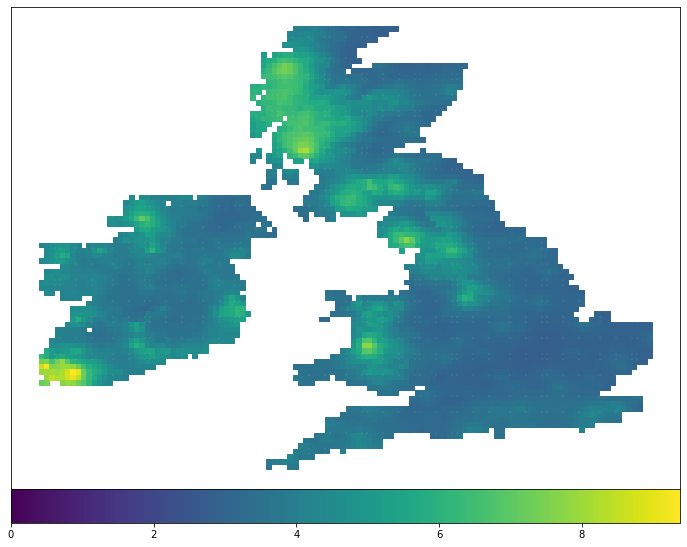

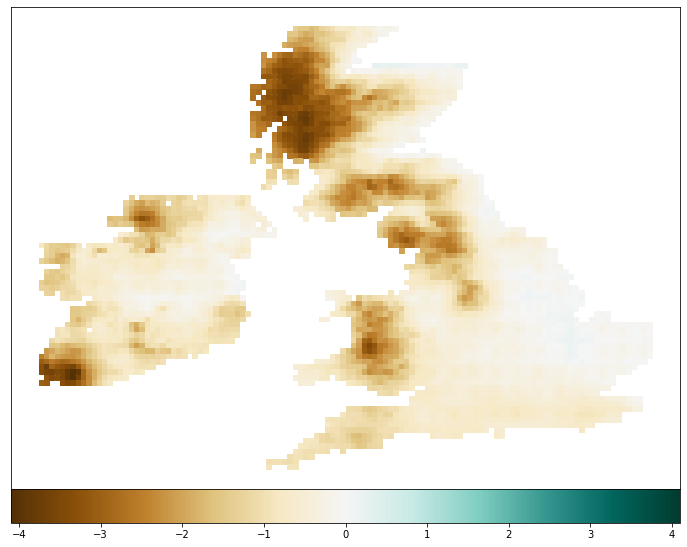

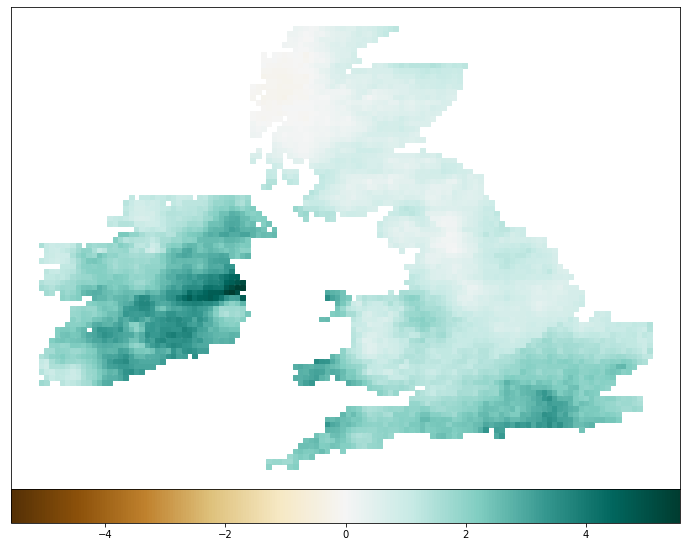

In [ ]:

for map_id,map in enumerate([MAB_map,RMSB_map,Bias_map,Sampled_bias]):
    fig = plt.gcf()
    fig.set_size_inches(12,9.5)
    if map_id in [2,3]:
        plt.scatter([GNM_landonly[loc][5][1] for loc in range(4086)],[-GNM_landonly[loc][5][0] for loc in range(4086)],c=map,cmap='BrBG',s=24,marker='s',vmin=-np.max(np.abs(map)),vmax=np.max(np.abs(map)))
        plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
        plt.yticks([])
        plt.xticks([])
        plt.show()
        continue
    plt.scatter([GNM_landonly[loc][5][1] for loc in range(4086)],[-GNM_landonly[loc][5][0] for loc in range(4086)],c=map,s=24,marker='s',vmin=0)
    plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
    plt.yticks([])
    plt.xticks([])
    plt.show()

### Median VS Observed

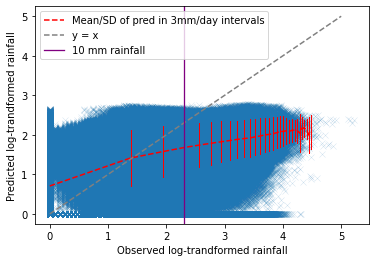

In [ ]:
# median vs observed
binned_median_means = [np.log(np.mean(g_median_all[np.logical_and(all_target_rain.flatten()>-0.01+k*3, all_target_rain.flatten()<3+k*3     )])+1) for k in range(30)]
binned_median_std = [np.std(np.log(1+g_median_all[np.logical_and(all_target_rain.flatten()>-0.01+k*3, all_target_rain.flatten()<3+k*3     )])) for k in range(30)]

plt.plot(np.log([i for i in range(1,30*3,3)]),binned_median_means, color='red',linestyle='dashed',label='Mean/SD of pred in 3mm/day intervals')

for i,v in enumerate(range(1,30*3,3)):
    if i==0:
        continue
    plt.plot(np.log([v,v]),[binned_median_means[i]+binned_median_std[i] ,binned_median_means[i]-binned_median_std[i] ],'r',linewidth=1)

plt.plot([0,5],[0,5],linestyle='dashed',color='grey',label='y = x')
plt.scatter(np.log(all_target_rain.flatten()+1),np.log(g_median_all+1),marker='x',linewidths=0.3,alpha=0.3)

plt.axvline(x = np.log(10), color = 'purple', label = '10 mm rainfall',linewidth=1.3)

plt.legend(loc='upper left')

plt.xlabel('Observed log-trandformed rainfall')
plt.ylabel('Predicted log-trandformed rainfall')
plt.show()

### CRPS

In [89]:
def estimate_CRPS_score_fast(obs,sims):
    '''
    obs: one vector of observations [y_1, y_2, ... y_n], ideally n corresponds to locations.
    sims: m vectors of simulations, each vector has length n. [[x_11, x_21,..., x_n1] ,..., [x_1m, x_2m,..., x_nm] ]

    returns: a vector [s1, ... , sn] of one score per location. this is for a single day, so would still need to average across days.
    '''
    m = len(sims)

    obs= np.array(obs)
    sims=np.array(sims)

    # |X-x|    
    diff_X_x = np.mean(
        np.abs(
            np.tile(obs,(m,1)) - sims
            ),
        axis=0)

    #|X-X'|
    diff_X_tilde_X = np.sum(
        np.abs(
            np.tile(sims,(m,1))-
            np.repeat(sims,m,axis=0)
            )
            ,axis=0
        )/(m*m-1)

    return 2*diff_X_x - diff_X_tilde_X 

    

In [91]:
sims_all_copula = np.array(sim_test) # 100,4087

In [101]:
len(sims_all_copula[0])

100

In [122]:
q_crps = []
for i,d in tqdm(enumerate(day_subset)):
    q_crps.append( estimate_CRPS_score_fast([GNM_landonly[l][0][d] for l in range(len(GNM_landonly))], all_sims_dumb[i] ) )

256it [02:19,  1.84it/s]


In [123]:
np.mean(q_crps) #4.053006626437677


7.246677883027779

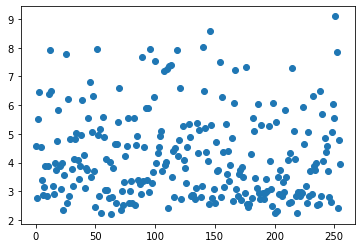

In [111]:
plt.scatter(range(256),np.mean(q_crps,axis=1))

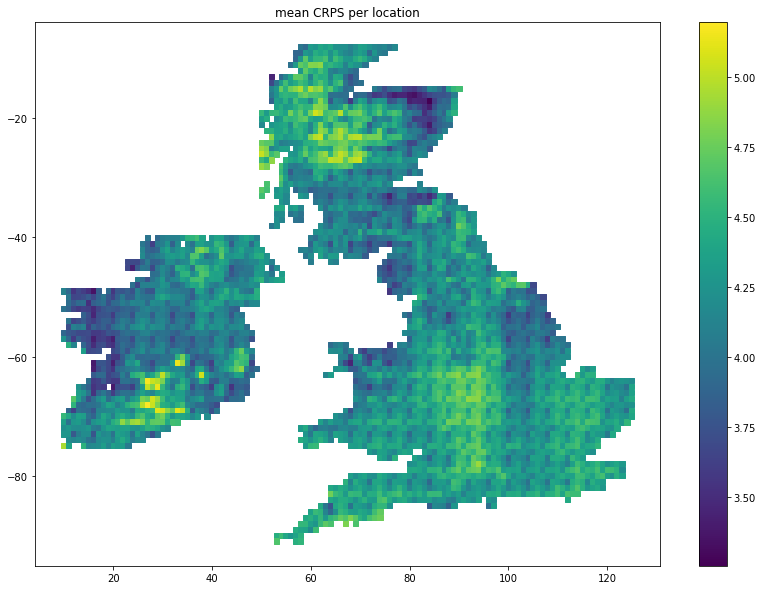

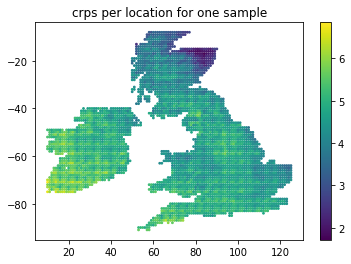

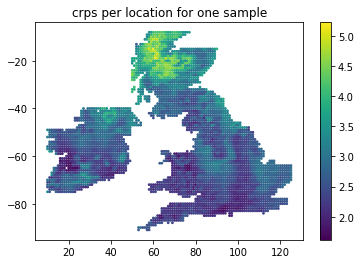

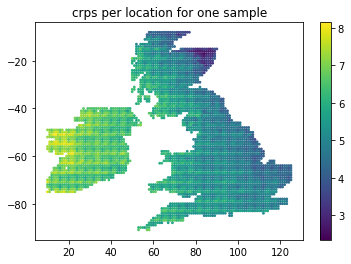

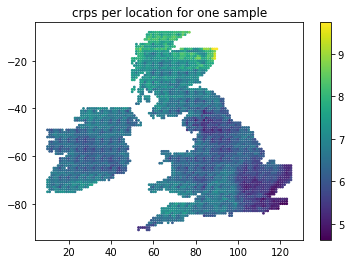

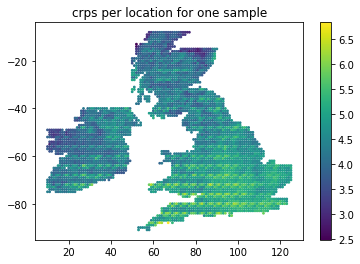

In [112]:
fig = plt.gcf() 
fig.set_size_inches(14,10)
plt.scatter([GNM_landonly[l][5][1] for l in range(len(GNM_landonly))],[-GNM_landonly[l][5][0] for l in range(len(GNM_landonly))],c=np.mean(q_crps,axis=0),s=27,marker='s')
plt.colorbar()
plt.title('mean CRPS per location')
plt.show()
for score in q_crps[:5]:
    plt.scatter([GNM_landonly[l][5][1] for l in range(len(GNM_landonly))],[-GNM_landonly[l][5][0] for l in range(len(GNM_landonly))],c=score,s=3)
    plt.colorbar()
    plt.title('crps per location for one sample')
    plt.show()

### Spatial Scoring Rule

In [ ]:
# Do Energy score + Spatial
# Follow what Lorenzo did in E.4.2 and understand why those choices were made. Have to justify them in my paper.

### Rank histogram

In [69]:
#GNM_landonly[location][param][day]
# 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'

def get_cdf_gnm(day):
    p_times_cdf = np.multiply( #p*cdf(y)
        np.array([GNM_landonly[l][4][day] for l in range(len(GNM_landonly))]),
        scs.gamma(
            a=[1/GNM_landonly[l][1][day] for l in range(len(GNM_landonly))],
            scale=np.multiply([GNM_landonly[l][1][day] for l in range(len(GNM_landonly))],[GNM_landonly[l][0][day] for l in range(len(GNM_landonly))])
            ).cdf([GNM_landonly[l][3][day] for l in range(len(GNM_landonly))]))
    
    where_0 = np.argwhere(p_times_cdf==0).flatten()
    where_rain = np.argwhere(p_times_cdf>0).flatten()

    p_times_cdf[where_0] = np.random.uniform( # replace censored by u~[0,1-p]
        low=np.zeros(len(where_0)),
        high=(1-np.array([GNM_landonly[l][4][day] for l in range(len(GNM_landonly))])[where_0]).flatten()
        )
    
    p_times_cdf[where_rain] = (1-np.array([GNM_landonly[l][4][day] for l in range(len(GNM_landonly))]))[where_rain] + p_times_cdf[where_rain] # uncensored = (1-p) + p*cdf(y)

    return p_times_cdf

In [70]:
obs_u_all = []
for d in tqdm(range(len(GNM_landonly[0][0]))):
    obs_u_all.append(get_cdf_gnm(d))

100%|██████████| 7301/7301 [02:59<00:00, 40.66it/s]


(array([0.98161857, 0.97864251, 0.97957897, 0.98812185, 0.99906954,
        1.01136999, 1.02601243, 1.03284154, 1.04237115, 1.04817753,
        1.04794216, 1.0463021 , 1.04065403, 1.03421943, 1.02292831,
        1.01210542, 0.99817748, 0.98588038, 0.97085097, 0.95812836,
        0.94106939, 0.92277996, 0.90725969, 0.90099932, 1.11679787]),
 array([3.85254961e-08, 4.00098026e-02, 8.00195667e-02, 1.20029331e-01,
        1.60039095e-01, 2.00048859e-01, 2.40058623e-01, 2.80068387e-01,
        3.20078151e-01, 3.60087915e-01, 4.00097679e-01, 4.40107443e-01,
        4.80117208e-01, 5.20126972e-01, 5.60136736e-01, 6.00146500e-01,
        6.40156264e-01, 6.80166028e-01, 7.20175792e-01, 7.60185556e-01,
        8.00195320e-01, 8.40205084e-01, 8.80214848e-01, 9.20224612e-01,
        9.60234377e-01, 1.00024414e+00]),
 <BarContainer object of 25 artists>)

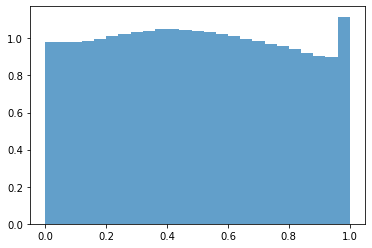

In [71]:
obs_u_all = np.array(obs_u_all).flatten()
plt.hist(obs_u_all,bins=25,density=True,alpha=0.7)


In [11]:
# Save
'''with open('obs_u_all_.txt','wb') as f:
    pickle.dump(obs_u_all_,f)
'''
#Load 
with open('obs_u_all_.txt','rb') as f:
    obs_u_all_ = pickle.load(f)

C:\Users\u1819911\AppData\Local\Temp\ipykernel_2616\1106313645.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  obs_u_all = np.concatenate(np.array(obs_u_all_).flatten()).flatten()


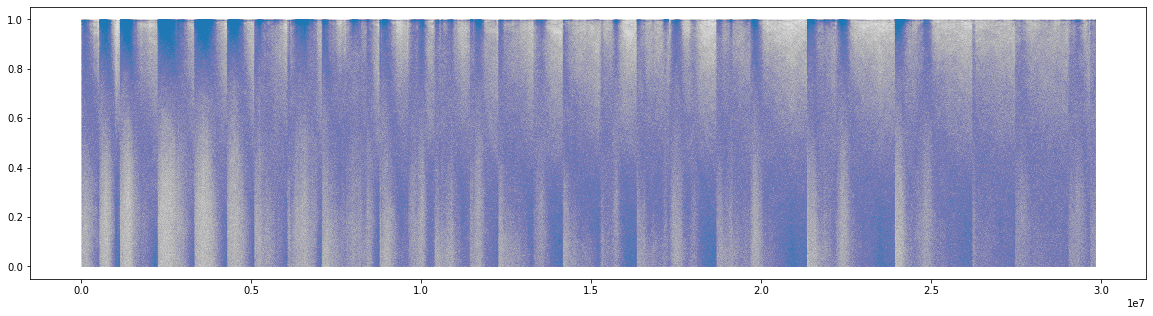

In [13]:
plt.figure(figsize=(20,5))
obs_u_all = np.concatenate(np.array(obs_u_all_).flatten()).flatten()
plt.scatter( range(len(obs_u_all)),obs_u_all,s=0.000005)
plt.show()

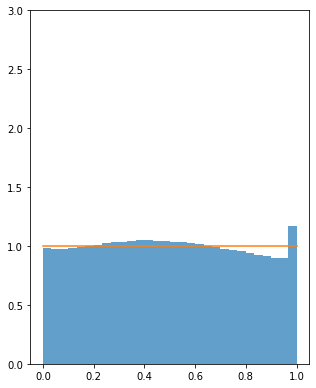

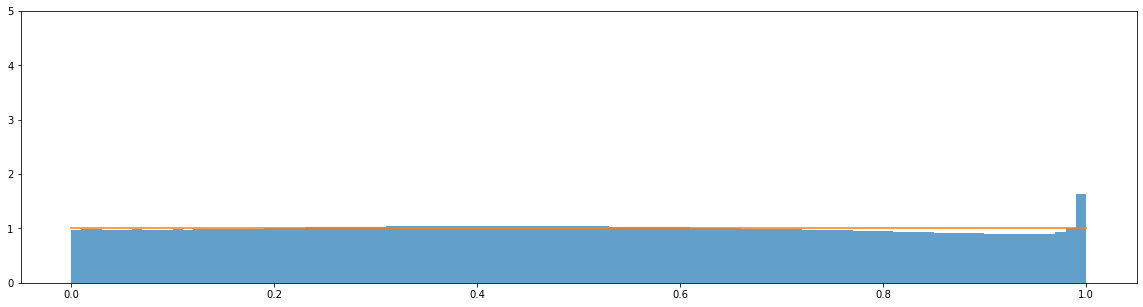

In [14]:
plt.figure(figsize=(5,6.5))
plt.hist(obs_u_all,bins=30,density=True,alpha=0.7)
plt.plot([0,1],[1,1])
plt.ylim(0,3)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(obs_u_all,bins=100,density=True,alpha=0.7)
plt.plot([0,1],[1,1])   
plt.ylim(0,5)
plt.show()

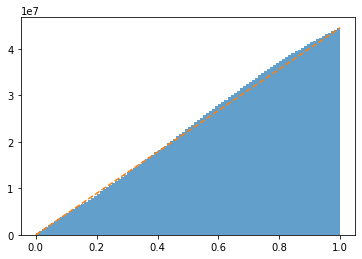

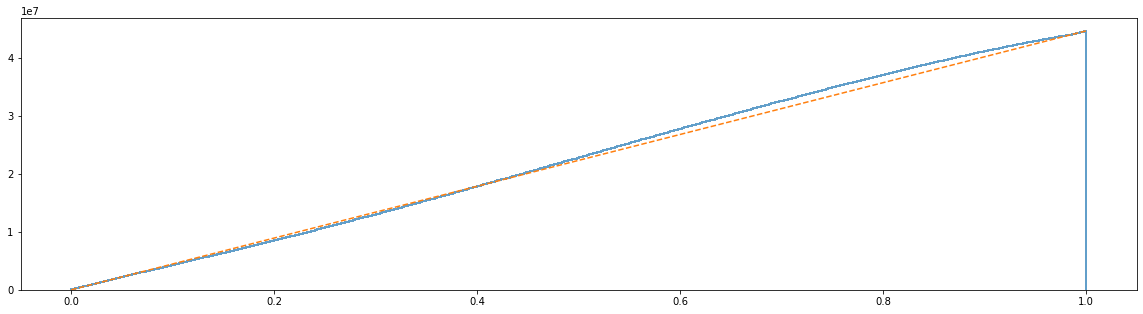

In [23]:
plt.hist(obs_u_all,bins=100,cumulative=True,alpha=0.7,align='mid')
plt.plot([0,1],[0,len(obs_u_all)],linestyle='dashed')
plt.show()
plt.figure(figsize=(20,5))
plt.hist(obs_u_all,bins=500,cumulative=True,alpha=0.7,align='mid',histtype='step',linewidth=2)
plt.plot([0,1],[0,len(obs_u_all)],linestyle='dashed')
plt.show()

### Correlation map

In [30]:
for i,v in enumerate(np.array([GNM_landonly[l][5] for l in range(len(GNM_landonly))])): # closest to center 1107 [43 70]

    if (v==[48,76]).all():
        print(i,v)

3225 [48 76]


In [199]:
corr_mat.shape


(4087, 4087)

In [210]:
all_target_rain.shape

(4087, 7301)

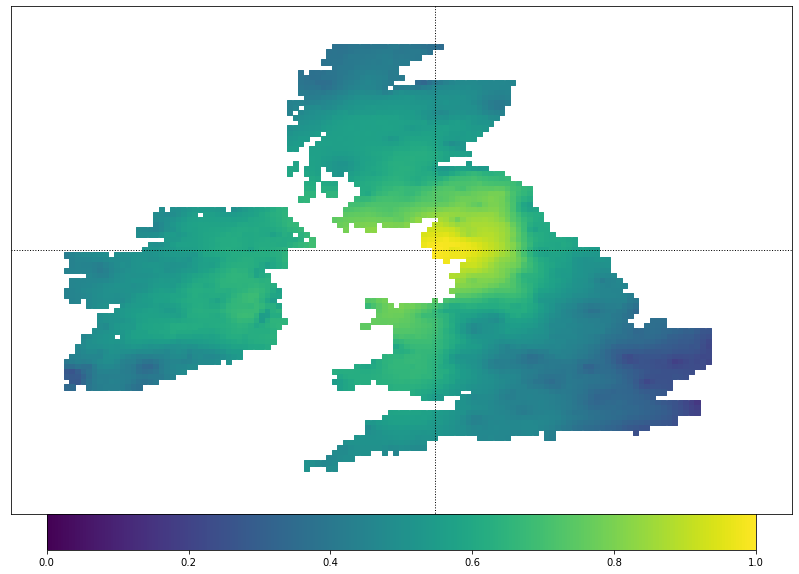

In [56]:
# observed corr
corr_mat = np.corrcoef( np.array([np.array([GNM_landonly[loc][3][day]for day in day_subset])for loc in range(4087)]).flatten().reshape(4087,len(day_subset)))
fig = plt.gcf() 
fig.set_size_inches(14,10)
plt.xlim(0,140)
plt.ylim(-100,0)
plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=corr_mat[:,3225  ],s=27,marker='s',vmin=0)
plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
plt.plot([76,76],[0,-100],color='black',linestyle='dotted',linewidth=1)
plt.plot([0,140],[-48,-48],color='black',linestyle='dotted',linewidth=1)
plt.yticks([])
plt.xticks([])
plt.show()

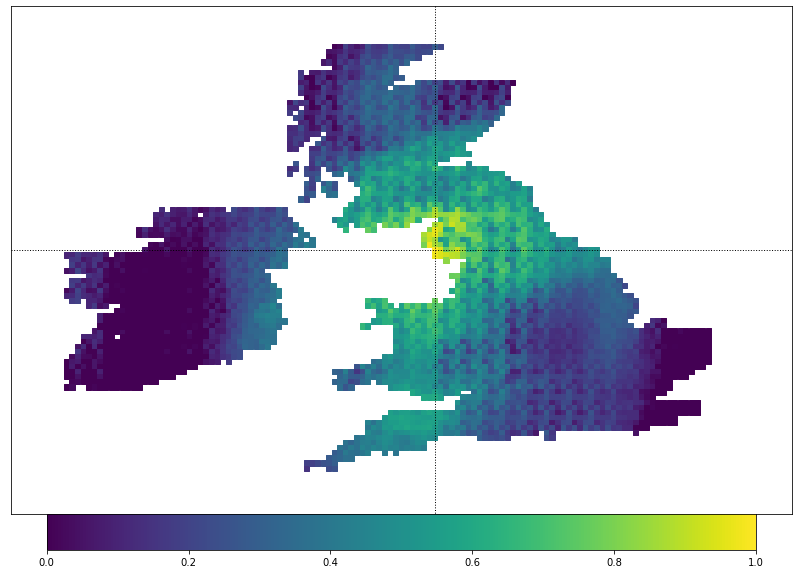

In [57]:
# sim corr
corr_mat = np.corrcoef(np.concatenate(np.array(sims_all_copula),0).transpose())
fig = plt.gcf() 
fig.set_size_inches(14,10)
plt.xlim(0,140)
plt.ylim(-100,0)
plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=corr_mat[:,3225      ],s=27,marker='s',vmin=0)
plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
plt.plot([76,76],[0,-100],color='black',linestyle='dotted',linewidth=1)
plt.plot([0,140],[-48,-48],color='black',linestyle='dotted',linewidth=1)
plt.yticks([])
plt.xticks([])
plt.show()

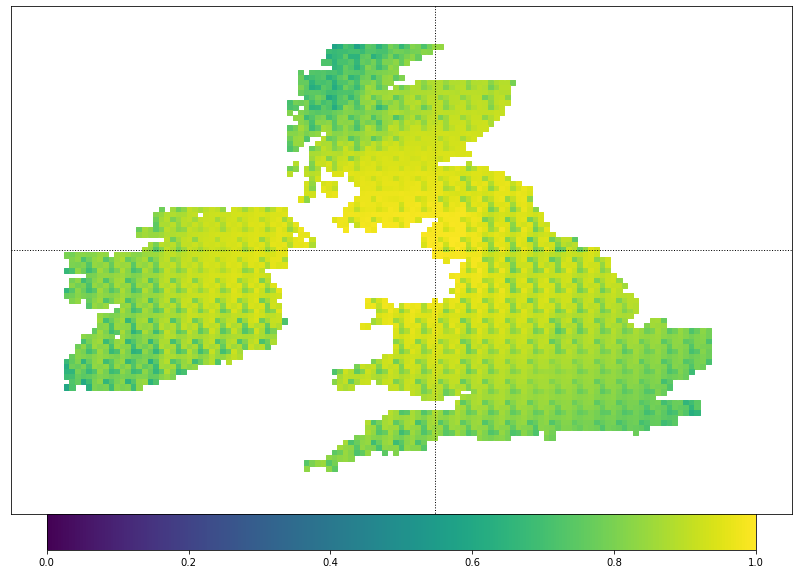

In [58]:
# median of sim corr
corr_mat = np.corrcoef(np.array(g_median_pred_all).transpose())
fig = plt.gcf() 
fig.set_size_inches(14,10)
plt.xlim(0,140)
plt.ylim(-100,0)
plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(sim_test[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(sim_test[0]))],c=corr_mat[:,3225   ],s=27,marker='s',vmin=0)
plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
plt.plot([76,76],[0,-100],color='black',linestyle='dotted',linewidth=1)
plt.plot([0,140],[-48,-48],color='black',linestyle='dotted',linewidth=1)
plt.yticks([])
plt.xticks([])
plt.show()

### Plots comparing experiements:

Text(0.5, 0, 'Precipitation threshold (mm)')

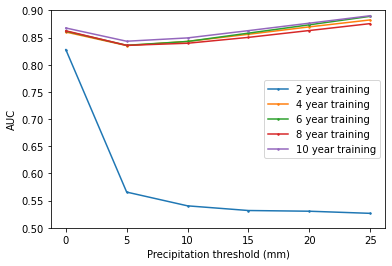

In [37]:
plt.plot([0,5,10,15,20,25],[0.8279,0.5657,0.5404,0.5318,0.5305,0.5266],marker='.',markersize=3,label='2 year training')
plt.plot([0,5,10,15,20,25],[0.8601,0.8352,0.8428,0.8560,0.8696,0.8824],marker='.',markersize=3,label='4 year training')
plt.plot([0,5,10,15,20,25],[0.8617,0.8357,0.8428,0.8581,0.8734,0.8890],marker='.',markersize=3,label='6 year training')
plt.plot([0,5,10,15,20,25],[0.8624,0.8356,0.8395,0.8503,0.8629,0.8756],marker='.',markersize=3,label='8 year training')
plt.plot([0,5,10,15,20,25],[0.8676,0.8432,0.8493,0.8627,0.8764,0.8901],marker='.',markersize=3,label='10 year training')
plt.ylim((0.5,0.9))
plt.legend()
plt.ylabel('AUC')
plt.xlabel('Precipitation threshold (mm)')

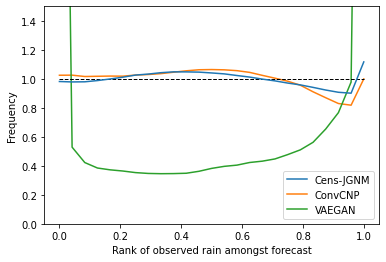

In [79]:
rank_hist_20y = [0.98161857, 0.97864251, 0.97957897, 0.98812185, 0.99906954,
        1.01136999, 1.02601243, 1.03284154, 1.04237115, 1.04817753,
        1.04794216, 1.0463021 , 1.04065403, 1.03421943, 1.02292831,
        1.01210542, 0.99817748, 0.98588038, 0.97085097, 0.95812836,
        0.94106939, 0.92277996, 0.90725969, 0.90099932, 1.11679787]
rank_hist_ConvCNP = [1.0248582 , 1.02541557, 1.01611493, 1.01767681, 1.0191044 ,
        1.01836537, 1.02601098, 1.0297123 , 1.03591013, 1.04573709,
        1.05543907, 1.06261969, 1.06408996, 1.06217953, 1.05639312,
        1.04456025, 1.02403457, 1.0044901 , 0.98368496, 0.9558987 ,
        0.91061193, 0.86961335, 0.8297823 , 0.81821259, 0.99948386]
rank_hist_VAEGAN = [6.93139183, 0.5285968 , 0.42249608, 0.38479105, 0.37226054, 0.36413387, 0.35319237, 0.34742652, 0.34565591, 0.34638231, 0.34872044, 0.36218165, 0.38218053, 0.39632275, 0.40476722, 0.42288198, 0.43212096, 0.4475117 , 0.47736245, 0.51023234, 0.56221579, 0.65403809, 0.76690348, 0.97772021, 7.45851312]

plt.plot(np.linspace(0,1,25),rank_hist_20y,label='Cens-JGNM',alpha=1,zorder=5)
plt.plot(np.linspace(0,1,25),rank_hist_ConvCNP,label='ConvCNP',alpha=1)
plt.plot(np.linspace(0,1,25),rank_hist_VAEGAN,label='VAEGAN')
plt.plot([0,1],[1,1],color='black',linestyle='dashed',linewidth=1)
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Rank of observed rain amongst forecast')
plt.ylim((0,1.5))
plt.show()

### IFS predictions

These are pointwise forecasts. Should use them as a baseline for pointwise metrics.

In [46]:
IFS_2009 = np.fromfile('IFS_All_2009-07_2019-07_pred.dat', dtype="byte")
IFS_1999 = np.fromfile('IFS_All_1999-07_2019-07_pred.dat', dtype="byte")
IFS_1987 = np.fromfile('IFS_All_1987-07_2019-07_pred.dat', dtype="byte")

In [43]:
print(len(IFS_2009),len(IFS_1999),len(IFS_1987))

409165539 818330763 1309261836
